# 추천 시스템 - 영화 데이터셋과 Embedding & Ranking 알고리즘으로 추천시스템 만들기

## Step 1. Word2Vec 알고리즘 기반 추천 후보군 생성

#### Rating Matrix 기반 추천시스템의 한계

    [Memory Based Recommendations]
    1. 만약 유저, 영화의 수가 3000이 아니라 3천만 개 라면?
    2. Matrix의 크기는 30,000,000 X 30,000,000
    3. 연산량 자체도 문제가 되지만, Extreme Sparse 벡터가 되면서 정확도 역시 현저하게 떨어지게 됨
    4. 차원축소, ALS 등의 방법으로 어느정도 극복할 수 있지만, 근본적인 해결책이 되지는 못함

    - Recommendation in Large Scale System
  - Architecture
  ![recsys_architecture](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2F30pCp%2Fbtqv7PV6365%2FCkl5dwvSoQF3RdneCIzGr1%2Fimg.png)
  - 데이터 수집과 처리 단계를 제외하면, 추천시스템은 다음과 같은 레이어로 구분되는 추세
    - `Generate Candidates` : 수백, 수천만개의 Item 중, 후보가 될 만한 Item을 추출. 여기에 CF 등의 방법을 사용할 수도 있지만, 일반적으로는 연산량이 작은 여러 개의 전략(시나리오)들을 합쳐서 coverage 자체를 확보하는 역할을 함. 예를 들면 인기도가 높은 Item, 연관성이 높은 Item 등을 별개의 전략으로 추출하는 것.
    - `Intention Predict` : User의 Context에 기반하여 Candidates를 한 번 더 좁혀주는 역할. 반드시 필요한 단계는 아니며, Candidates를 추렸음에도 여전히 Large Scale 문제를 가지고 있는 경우에 필터링의 역할로 사용할 수 있음.
    - `Personalized Ranking` : 일반적으로 추천시스템에서 추천이 잘 되었는지를 평가하는 지표는 CTR, CVR 같은 지표. 이 지표들을 Maximize 할 수 있는 방법으로 개인화 모델을 학습. 일반적인 Classifier를 생각해도 무방하며, 학습 데이터셋을 잘 구축하는 것이 좋은 추천 랭킹모델을 만드는 것.

![recsys_architecture2](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FUsbKo%2Fbtqv7PBN46z%2Fd4m5pf7lrKs1CqxzkROY81%2Fimg.png)


-----

#### Word2Vec 기반의 Movie2Vec 만들기

    [Word2Vec]
    1. 임베딩(Embedding) 방법론 중 가장 대중적이고 성능이 좋은 방법
    2. 같은 문장 내, 혹은 비슷한 위치에 등장하는 단어들은 유사한 의미를 가지고 있을 것이라는 가정.
    3. 원래는 단어를 벡터로 표현하는 방법으로 고안되었지만, word2vec의 메커니즘을 다양하게 활용할 수 있음
    4. Word2Vec은 중심 단어와 주변 단어와의 연관성을 학습하여 벡터로 표현함.
      - 예시 문장 : "역시 성공은 고난을 동반 말없이 등산을 등반하는 것처럼"
      - 만약 "성공"이라는 단어를 중심 단어로 활용한다면, [역시, _, 고난을, 동반] 이러한 주변 단어를 가지고 중심에 있는 단어의 벡터를 학습할 수 있게 됨. (Skip-gram 방식. CBOW는 반대)

### 데이터 불러오기

In [1]:
import pandas as pd

rating_url = 'https://raw.githubusercontent.com/yoonkt200/python-data-analysis/master/data/ml-1m/ratings.dat'
rating_df = pd.io.parsers.read_csv(rating_url, names=['user_id', 'movie_id', 'rating', 'time'], delimiter='::', engine ='python')

movie_url = 'https://raw.githubusercontent.com/yoonkt200/python-data-analysis/master/data/ml-1m/movies.dat'
movie_df = pd.io.parsers.read_csv(movie_url, names=['movie_id', 'title', 'genre'], delimiter='::', engine ='python', encoding='ISO-8859-1')

user_url = 'https://raw.githubusercontent.com/yoonkt200/python-data-analysis/master/data/ml-1m/users.dat'
user_df = pd.io.parsers.read_csv(user_url, names=['user_id', 'gender', 'age', 'occupation', 'zipcode'], delimiter='::', engine ='python')

In [2]:
# EDA & 전처리 - 사용자별 시청 목록 추출
def get_movie_list_sort_by_time(x):
  return x.sort_values(['time'])['movie_id'].tolist()

user_watch_list = rating_df.groupby('user_id')[['movie_id', 'time']].apply(lambda x: get_movie_list_sort_by_time(x))

In [3]:
user_watch_list[:3]

user_id
1    [3186, 1721, 1022, 1270, 2340, 1836, 3408, 120...
2    [1198, 1217, 1210, 2717, 1293, 2943, 1225, 119...
3    [593, 2858, 3534, 1968, 1961, 1431, 1266, 1378...
dtype: object

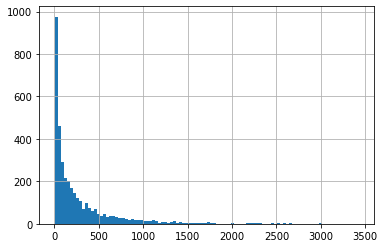

In [4]:
rating_df['movie_id'].value_counts().hist(bins=100)

In [5]:
movie_df.head()

,movie_id,title,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [6]:
# 영화 개봉년도 피쳐 생성
movie_df['released_year_area'] = movie_df['title'].apply(lambda x: x[-5:-2]+"0")
movie_df.head()

,movie_id,title,genre,released_year_area
0,1,Toy Story (1995),Animation|Children's|Comedy,1990
1,2,Jumanji (1995),Adventure|Children's|Fantasy,1990
2,3,Grumpier Old Men (1995),Comedy|Romance,1990
3,4,Waiting to Exhale (1995),Comedy|Drama,1990
4,5,Father of the Bride Part II (1995),Comedy,1990


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


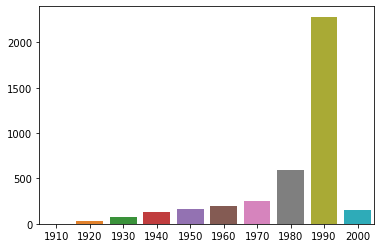

In [7]:
import seaborn as sns

released_year_area = movie_df['released_year_area'].value_counts().sort_index()
sns.barplot(released_year_area.index, released_year_area.values);

In [8]:
# 영화 장르 피쳐 생성
movie_df['genre'].value_counts()

Drama                            843
Comedy                           521
Horror                           178
Comedy|Drama                     162
Comedy|Romance                   142
                                ... 
Children's|Sci-Fi                  1
Crime|Horror|Thriller              1
Adventure|Animation|Film-Noir      1
Adventure|Fantasy                  1
Adventure|Comedy|Romance           1
Name: genre, Length: 301, dtype: int64

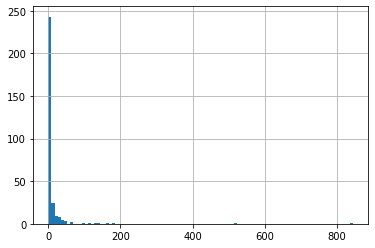

In [9]:
movie_df['genre'].value_counts().hist(bins=100)

In [10]:
movie_df['main_genre'] = movie_df['genre'].apply(lambda x: x.split("|")[0])

In [11]:
movie_df['main_genre'].value_counts()

Drama          1176
Comedy         1024
Action          503
Horror          262
Adventure       155
Crime           131
Documentary     123
Thriller        101
Animation        90
Children's       89
Romance          50
Sci-Fi           46
Mystery          36
Western          33
Film-Noir        25
Musical          25
War              12
Fantasy           2
Name: main_genre, dtype: int64

In [12]:
# Embedding - EDA 결과를 활용하여 Movie2Vec 학습
movie_df.head()

,movie_id,title,genre,released_year_area,main_genre
0,1,Toy Story (1995),Animation|Children's|Comedy,1990,Animation
1,2,Jumanji (1995),Adventure|Children's|Fantasy,1990,Adventure
2,3,Grumpier Old Men (1995),Comedy|Romance,1990,Comedy
3,4,Waiting to Exhale (1995),Comedy|Drama,1990,Comedy
4,5,Father of the Bride Part II (1995),Comedy,1990,Comedy


In [13]:
movie_meta_dict = movie_df.set_index('movie_id')[['released_year_area', 'main_genre']].to_dict()

In [14]:
movie2vec_dataset = []
for movie_list in user_watch_list:
  meta_list = []
  for movie_id in movie_list:
    word_meta_1 = "movie_id:" + str(movie_id)
    word_meta_2 = "year:" + movie_meta_dict['released_year_area'][movie_id]
    word_meta_3 = "genre:" + movie_meta_dict['main_genre'][movie_id]
    meta_list.append(word_meta_1)
    meta_list.append(word_meta_2)
    meta_list.append(word_meta_3)
  movie2vec_dataset.append(meta_list)

In [15]:
!pip install gensim

In [16]:
from gensim.models import Word2Vec

model = Word2Vec(movie2vec_dataset,
                 size=100,
                 window=6,  # 주변 word의 윈도우
                 sg=1,  # skip-gram OR cbow
                 hs=0,  # hierarchical softmax OR negative sampling
                 negative=20,  # negative sampling 파라미터
                 min_count=1,  # word의 등장 최소 횟수
                 iter=20)

In [17]:
# Embedding - 일부 데이터로 Movie2Vec 학습 결과 확인
model.wv.vectors.shape

(3734, 100)

In [18]:
model.wv.most_similar("movie_id:1", topn=5)

[('movie_id:1223', 0.840821385383606),
 ('movie_id:3429', 0.7486809492111206),
 ('movie_id:2324', 0.7059773206710815),
 ('movie_id:1537', 0.6819300055503845),
 ('movie_id:3114', 0.6790466904640198)]

In [19]:
movie_df[movie_df['movie_id'].isin([1223, 3429, 2324, 1537, 3114])]

,movie_id,title,genre,released_year_area,main_genre
1205,1223,"Grand Day Out, A (1992)",Animation|Comedy,1990,Animation
1499,1537,Shall We Dance? (Shall We Dansu?) (1996),Comedy,1990,Comedy
2255,2324,Life Is Beautiful (La Vita è bella) (1997),Comedy|Drama,1990,Comedy
3045,3114,Toy Story 2 (1999),Animation|Children's|Comedy,1990,Animation
3360,3429,Creature Comforts (1990),Animation|Comedy,1990,Animation


In [20]:
# Movie2Vec 모델로 Item2Item 후보군 생성
item2item = {}

# 영화별 연관 영화 k개씩 추출
k = 10
not_in_count = 0
for movie_id in movie_df['movie_id'].values:
  item2item[movie_id] = []
  try:
    sim_list = model.wv.most_similar("movie_id:" + str(movie_id), topn=k+10)
    for movie_tup in sim_list:
      tup_info = movie_tup[0].split(":")
      if (tup_info[0] == "movie_id") and (len(item2item[movie_id]) < 10):
        item2item[movie_id].append(tup_info[1])
  except:
    not_in_count += 1
    print("word", str(movie_id) ,"not in vocabulary")

word 51 not in vocabulary
word 109 not in vocabulary
word 115 not in vocabulary
word 143 not in vocabulary
word 284 not in vocabulary
word 285 not in vocabulary
word 395 not in vocabulary
word 399 not in vocabulary
word 400 not in vocabulary
word 403 not in vocabulary
word 604 not in vocabulary
word 620 not in vocabulary
word 625 not in vocabulary
word 629 not in vocabulary
word 636 not in vocabulary
word 654 not in vocabulary
word 675 not in vocabulary
word 676 not in vocabulary
word 683 not in vocabulary
word 693 not in vocabulary
word 699 not in vocabulary
word 713 not in vocabulary
word 721 not in vocabulary
word 723 not in vocabulary
word 727 not in vocabulary
word 738 not in vocabulary
word 739 not in vocabulary
word 752 not in vocabulary
word 768 not in vocabulary
word 770 not in vocabulary
word 772 not in vocabulary
word 773 not in vocabulary
word 777 not in vocabulary
word 794 not in vocabulary
word 795 not in vocabulary
word 797 not in vocabulary
word 812 not in vocabulary
wo

In [21]:
print("total:", not_in_count)

total: 177


In [22]:
str(item2item)[:100]

"{1: ['1223', '3429', '2324', '1537', '3114', '745', '2289', '1148', '1265', '2359'], 2: ['60', '3489"

In [23]:
 # 평균 평점 기반 Popular 후보군 생성
 mean_ratings = rating_df.groupby('movie_id')['rating'].agg(['mean', 'count'])

In [24]:
mean_ratings.head()

,mean,count
movie_id,,
1,4.146846,2077
2,3.201141,701
3,3.016736,478
4,2.729412,170
5,3.006757,296


In [25]:
mean_ratings['count'].value_counts()

1       114
2        89
4        45
3        42
5        39
       ... 
1568      1
1548      1
1546      1
1522      1
1995      1
Name: count, Length: 924, dtype: int64

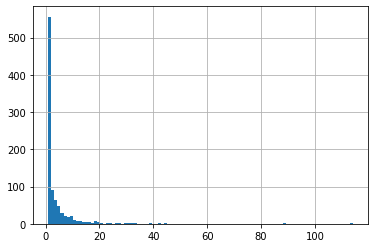

In [26]:
mean_ratings['count'].value_counts().hist(bins=100)

In [27]:
mean_ratings[mean_ratings['count']>10]['mean'].sort_values(ascending=False)

movie_id
2905    4.608696
2019    4.560510
318     4.554558
858     4.524966
745     4.520548
          ...   
3573    1.461538
1323    1.372093
1739    1.361702
1495    1.318182
3574    1.058824
Name: mean, Length: 3233, dtype: float64

In [28]:
# EDA & 전처리 - Popular 후보군 생성 결과 확인
mean_ratings[mean_ratings['count']>10]['mean'].sort_values(ascending=False)[:20]

movie_id
2905    4.608696
2019    4.560510
318     4.554558
858     4.524966
745     4.520548
50      4.517106
527     4.510417
1148    4.507937
922     4.491489
1198    4.477725
904     4.476190
1178    4.473913
260     4.453694
1212    4.452083
750     4.449890
3338    4.444444
720     4.426941
1207    4.425647
3435    4.415608
912     4.412822
Name: mean, dtype: float64

In [29]:
# 평점 높은 (popular) 상위 10개 영화
popular_movie_list = mean_ratings[mean_ratings['count']>10]['mean'].sort_values(ascending=False).index[:10].tolist()

In [30]:
popular_movie_list

[2905, 2019, 318, 858, 745, 50, 527, 1148, 922, 1198]

In [31]:
# EDA & 전처리 - 장르 & 연도 기준 Meta2Item 후보군 생성
merge_df = pd.merge(mean_ratings, movie_df, on='movie_id')
merge_df.head()

,movie_id,mean,count,title,genre,released_year_area,main_genre
0,1,4.146846,2077,Toy Story (1995),Animation|Children's|Comedy,1990,Animation
1,2,3.201141,701,Jumanji (1995),Adventure|Children's|Fantasy,1990,Adventure
2,3,3.016736,478,Grumpier Old Men (1995),Comedy|Romance,1990,Comedy
3,4,2.729412,170,Waiting to Exhale (1995),Comedy|Drama,1990,Comedy
4,5,3.006757,296,Father of the Bride Part II (1995),Comedy,1990,Comedy


In [32]:
# 장르&연도를 meta로 하여, meta별 상위 10개의 평점 높은 영화
def get_meta_popular_list(x, k):
  movie_id_list = x.sort_values(by=['mean'], ascending=False)['movie_id'].tolist()
  return movie_id_list[:k]

genre_popular = merge_df.groupby('main_genre').apply(lambda x: get_meta_popular_list(x, k=10))
year_popular = merge_df.groupby('released_year_area').apply(lambda x: get_meta_popular_list(x, k=10))

In [33]:
genre_popular.head()

main_genre
Action        [2905, 2019, 858, 1198, 260, 1221, 2028, 2571,...
Adventure     [3172, 1204, 1262, 3470, 1254, 919, 1303, 1259...
Animation     [745, 1148, 720, 1223, 3429, 3114, 1, 741, 276...
Children's    [1097, 1028, 34, 262, 3396, 755, 531, 3397, 55...
Comedy        [1830, 3233, 3607, 3030, 3307, 3022, 1136, 341...
dtype: object

In [34]:
year_popular.head()

released_year_area
1910                                   [3132, 2821, 2823]
1920    [3517, 3022, 3629, 2010, 3232, 1348, 3742, 330...
1930    [3382, 3307, 3134, 1260, 905, 919, 954, 950, 3...
1940    [3656, 1212, 3435, 912, 913, 923, 3089, 1284, ...
1950    [3172, 2019, 922, 904, 1178, 670, 668, 1250, 9...
dtype: object

In [35]:
# Meta 후보군 생성 결과 확인
genre_popular_dict = genre_popular.to_dict()

In [36]:
genre_popular_dict

{'Action': [2905, 2019, 858, 1198, 260, 1221, 2028, 2571, 1197, 1233],
 'Adventure': [3172, 1204, 1262, 3470, 1254, 919, 1303, 1259, 29, 1931],
 'Animation': [745, 1148, 720, 1223, 3429, 3114, 1, 741, 2761, 1023],
 "Children's": [1097, 1028, 34, 262, 3396, 755, 531, 3397, 551, 1012],
 'Comedy': [1830, 3233, 3607, 3030, 3307, 3022, 1136, 3410, 2324, 1234],
 'Crime': [3656, 50, 3517, 3435, 1260, 296, 1213, 1945, 608, 1617],
 'Documentary': [3881, 787, 3338, 2930, 128, 1147, 3679, 363, 1189, 2859],
 'Drama': [3382, 989, 3245, 53, 2503, 318, 527, 578, 2480, 439],
 'Fantasy': [792, 2021],
 'Film-Noir': [922, 913, 1252, 1267, 1284, 2186, 930, 541, 2203, 2066],
 'Horror': [3280, 1219, 1258, 1348, 2648, 1997, 2664, 1340, 1333, 2644],
 'Musical': [899, 914, 1947, 2565, 3606, 1035, 3545, 900, 3675, 2971],
 'Mystery': [904, 1212, 903, 950, 906, 1086, 2206, 1625, 931, 2467],
 'Romance': [928, 28, 932, 2708, 2721, 1684, 803, 2833, 3368, 976],
 'Sci-Fi': [750, 1199, 2010, 1206, 1301, 2660, 1921, 365

In [37]:
year_popular_dict = year_popular.to_dict()

In [38]:
year_popular_dict

{'1910': [3132, 2821, 2823],
 '1920': [3517, 3022, 3629, 2010, 3232, 1348, 3742, 3306, 1925, 3310],
 '1930': [3382, 3307, 3134, 1260, 905, 919, 954, 950, 3462, 1256],
 '1940': [3656, 1212, 3435, 912, 913, 923, 3089, 1284, 898, 953],
 '1950': [3172, 2019, 922, 904, 1178, 670, 668, 1250, 908, 2731],
 '1960': [3233, 3245, 2905, 557, 750, 1207, 3030, 1204, 1262, 1267],
 '1970': [3607, 3280, 858, 260, 1193, 1221, 1252, 1136, 3470, 1234],
 '1980': [1198, 3338, 1131, 1197, 1233, 2931, 1196, 1172, 1224, 3091],
 '1990': [989, 787, 1830, 53, 2503, 318, 745, 50, 527, 1148],
 '2000': [3881, 3888, 3897, 3949, 3578, 3911, 3647, 3353, 3851, 3317]}

### Point-wise 데이터셋 생성
#### Ranking Model

    [랭킹 모델의 형태와 역할]
    1. Binary Classification을 학습하는 Regressor가 가장 대표적인 예
    2. y=1은 User가 Item을 시청(혹은 구매 등)한 경우 -> **Ground Truth**
    3. f(x_ui) = X_u + X_i + b -> **X_u는 User의 여러가지 정보를 벡터로 나타낸 것, 그리고 X_i는 아이템의 여러가지 정보를 벡터로 나타낸 것**
    4. NDCG, AUC, Top@Precision... 등을 기준으로 모델을 학습 (랭킹 학습 방식인 Point-wise, Pair-wise 등을 기준으로 각각 다름)

![point-wise](https://drive.google.com/uc?id=1CA6paiEoEu2g6B3wX0ldyTxSA8-xVFYq)

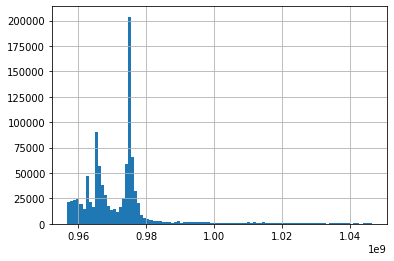

In [39]:
# 특정 시간 기준 데이터셋 분리
rating_df['time'].hist(bins=100)

In [40]:
rating_df['time'].quantile(q=0.8, interpolation='nearest')

975768738

In [41]:
train_df = rating_df[rating_df['time'] < 975768738]
test_df = rating_df[rating_df['time'] >= 975768738]

### User Profiling - 유저 속성 EDA (gender, age, occupation, zipcode)

In [42]:
# 1) Gender
user_df.head()

,user_id,gender,age,occupation,zipcode
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


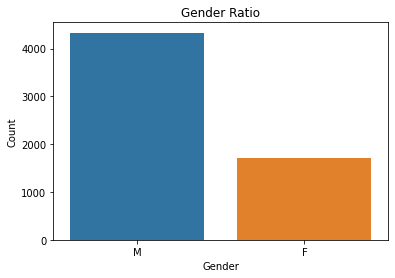

In [43]:
import matplotlib.pyplot as plt

gender = user_df['gender'].value_counts()
sns.barplot(gender.index, gender.values)
plt.title('Gender Ratio')
plt.ylabel('Count')
plt.xlabel('Gender')
plt.show()

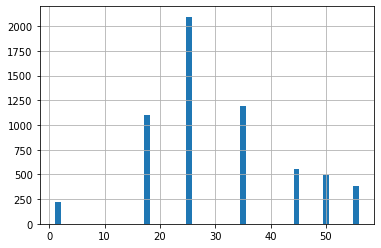

In [44]:
# 2) age
user_df['age'].hist(bins='auto')

In [45]:
user_df['age'].value_counts()

25    2096
35    1193
18    1103
45     550
50     496
56     380
1      222
Name: age, dtype: int64

In [46]:
def age_bucketize(age):
    if age == 1:
        return 'outlier'
    else:
        return str(age)[0] + "0"

user_df['age_bucket'] = user_df['age'].apply(lambda x: age_bucketize(x))
user_df['age_bucket'].value_counts()

20         2096
30         1193
10         1103
50          876
40          550
outlier     222
Name: age_bucket, dtype: int64

In [47]:
# 3) Occupation
user_df['occupation'].value_counts()

4     759
0     711
7     679
1     528
17    502
12    388
14    302
20    281
2     267
16    241
6     236
10    195
3     173
15    144
13    142
11    129
5     112
9      92
19     72
18     70
8      17
Name: occupation, dtype: int64

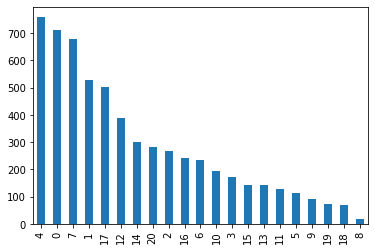

In [48]:
user_df['occupation'].value_counts().plot(kind='bar');

In [49]:
# 4) Zipcode
user_df['zipcode'].value_counts()

48104    19
22903    18
94110    17
55104    17
10025    16
         ..
01234     1
56342     1
36102     1
01464     1
80231     1
Name: zipcode, Length: 3439, dtype: int64

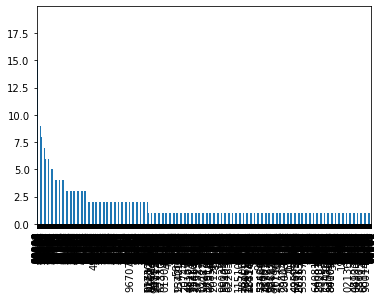

In [50]:
user_df['zipcode'].value_counts().plot(kind='bar');

### User Profiling - 유저 속성별 피쳐맵 생성

In [51]:
user_df.head()

,user_id,gender,age,occupation,zipcode,age_bucket
0,1,F,1,10,48067,outlier
1,2,M,56,16,70072,50
2,3,M,25,15,55117,20
3,4,M,45,7,02460,40
4,5,M,25,20,55455,20


#### 1) Gender

In [52]:
gender_list = user_df['gender'].unique()
gender_index = {}
for idx, gender in enumerate(gender_list):
  gender_index[gender] = idx + 1

In [53]:
gender_index

{'F': 1, 'M': 2}

#### 2) Age

In [54]:
age_list = user_df['age_bucket'].unique()
age_index = {}
for idx, age in enumerate(age_list):
  age_index[age] = idx + 1

In [55]:
age_index

{'10': 6, '20': 3, '30': 5, '40': 4, '50': 2, 'outlier': 1}

#### 3)Occupation

In [56]:
occupation_list = user_df['occupation'].unique()
occupation_index = {}
for idx, occupation in enumerate(occupation_list):
  occupation_index[occupation] = idx + 1

In [57]:
occupation_index

{0: 10,
 1: 7,
 2: 17,
 3: 11,
 4: 13,
 5: 19,
 6: 21,
 7: 4,
 8: 15,
 9: 6,
 10: 1,
 11: 14,
 12: 8,
 13: 20,
 14: 12,
 15: 3,
 16: 2,
 17: 9,
 18: 18,
 19: 16,
 20: 5}

#### Item Profiling - 영화 속성별 피쳐맵 생성 (장르, 년도)

#### 1) Genre

In [58]:
merge_df.head()

,movie_id,mean,count,title,genre,released_year_area,main_genre
0,1,4.146846,2077,Toy Story (1995),Animation|Children's|Comedy,1990,Animation
1,2,3.201141,701,Jumanji (1995),Adventure|Children's|Fantasy,1990,Adventure
2,3,3.016736,478,Grumpier Old Men (1995),Comedy|Romance,1990,Comedy
3,4,2.729412,170,Waiting to Exhale (1995),Comedy|Drama,1990,Comedy
4,5,3.006757,296,Father of the Bride Part II (1995),Comedy,1990,Comedy


In [59]:
genre_list = merge_df['main_genre'].unique()
genre_index = {}
for idx, genre in enumerate(genre_list):
  genre_index[genre] = idx + 1

In [60]:
genre_index

{'Action': 4,
 'Adventure': 2,
 'Animation': 1,
 "Children's": 9,
 'Comedy': 3,
 'Crime': 7,
 'Documentary': 10,
 'Drama': 5,
 'Fantasy': 17,
 'Film-Noir': 15,
 'Horror': 12,
 'Musical': 18,
 'Mystery': 14,
 'Romance': 8,
 'Sci-Fi': 11,
 'Thriller': 6,
 'War': 16,
 'Western': 13}

#### 2) Year

In [61]:
year_list = merge_df['released_year_area'].unique()
year_index = {}
for idx, year in enumerate(year_list):
  year_index[year] = idx + 1

In [62]:
year_index

{'1910': 9,
 '1920': 8,
 '1930': 5,
 '1940': 6,
 '1950': 7,
 '1960': 4,
 '1970': 2,
 '1980': 3,
 '1990': 1,
 '2000': 10}

### Context Profiling - 특정 시간 기준 유저 행동 EDA (시청한 영화 정보, 시청한 영화 점수 분포)

In [63]:
train_df.head()

,user_id,movie_id,rating,time
94507,635,1251,4,975768620
94513,635,3948,4,975768294
94518,635,1270,4,975768106
94519,635,1279,5,975768520
94522,635,1286,4,975768106


In [64]:
train_df = pd.merge(train_df, movie_df, on='movie_id')
train_df = pd.merge(train_df, user_df, on='user_id')

In [65]:
train_df.head()

,user_id,movie_id,rating,time,title,genre,released_year_area,main_genre,gender,age,occupation,zipcode,age_bucket
0,635,1251,4,975768620,8 1/2 (1963),Drama,1960,Drama,M,56,17,33785,50
1,635,3948,4,975768294,Meet the Parents (2000),Comedy,2000,Comedy,M,56,17,33785,50
2,635,1270,4,975768106,Back to the Future (1985),Comedy|Sci-Fi,1980,Comedy,M,56,17,33785,50
3,635,1279,5,975768520,Night on Earth (1991),Comedy|Drama,1990,Comedy,M,56,17,33785,50
4,635,1286,4,975768106,Somewhere in Time (1980),Drama|Romance,1980,Drama,M,56,17,33785,50


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


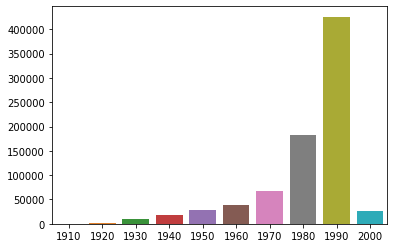

In [66]:
# 시청한 영화 정보 탐색
released_year_area = train_df['released_year_area'].value_counts().sort_index()
sns.barplot(released_year_area.index, released_year_area.values)

In [67]:
train_df['main_genre'].value_counts()

Comedy         219077
Action         210721
Drama          163949
Horror          36100
Adventure       35315
Crime           30569
Animation       29121
Children's      17088
Thriller        13974
Sci-Fi           9144
Mystery          8229
Film-Noir        7742
Musical          5600
Documentary      5283
Western          4654
Romance          2122
War               809
Fantasy           667
Name: main_genre, dtype: int64

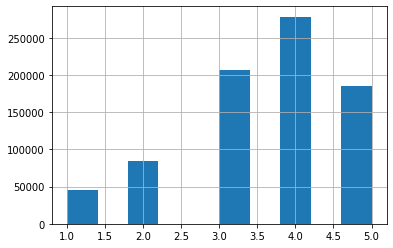

In [68]:
# 시청한 영화 점수 분포 탐색
train_df['rating'].hist()

### Feature Mapping - Profiling 피처맵 맵핑

In [69]:
train_df.head()

,user_id,movie_id,rating,time,title,genre,released_year_area,main_genre,gender,age,occupation,zipcode,age_bucket
0,635,1251,4,975768620,8 1/2 (1963),Drama,1960,Drama,M,56,17,33785,50
1,635,3948,4,975768294,Meet the Parents (2000),Comedy,2000,Comedy,M,56,17,33785,50
2,635,1270,4,975768106,Back to the Future (1985),Comedy|Sci-Fi,1980,Comedy,M,56,17,33785,50
3,635,1279,5,975768520,Night on Earth (1991),Comedy|Drama,1990,Comedy,M,56,17,33785,50
4,635,1286,4,975768106,Somewhere in Time (1980),Drama|Romance,1980,Drama,M,56,17,33785,50


In [70]:
train_df = train_df[['user_id', 'movie_id', 'rating', 'released_year_area', 'main_genre', 'gender', 'occupation', 'age_bucket']]
train_df['released_year_area'] = train_df['released_year_area'].apply(lambda x: year_index[x])
train_df['main_genre'] = train_df['main_genre'].apply(lambda x: genre_index[x])
train_df['gender'] = train_df['gender'].apply(lambda x: gender_index[x])
train_df['occupation'] = train_df['occupation'].apply(lambda x: occupation_index[x])
train_df['age_bucket'] = train_df['age_bucket'].apply(lambda x: age_index[x])

In [71]:
train_df.head()

,user_id,movie_id,rating,released_year_area,main_genre,gender,occupation,age_bucket
0,635,1251,4,4,5,2,9,2
1,635,3948,4,10,3,2,9,2
2,635,1270,4,3,3,2,9,2
3,635,1279,5,1,3,2,9,2
4,635,1286,4,3,5,2,9,2


In [72]:
test_df = pd.merge(test_df, movie_df, on='movie_id')
test_df = pd.merge(test_df, user_df, on='user_id')
test_df.head()

,user_id,movie_id,rating,time,title,genre,released_year_area,main_genre,gender,age,occupation,zipcode,age_bucket
0,1,1193,5,978300760,One Flew Over the Cuckoo's Nest (1975),Drama,1970,Drama,F,1,10,48067,outlier
1,1,661,3,978302109,James and the Giant Peach (1996),Animation|Children's|Musical,1990,Animation,F,1,10,48067,outlier
2,1,914,3,978301968,My Fair Lady (1964),Musical|Romance,1960,Musical,F,1,10,48067,outlier
3,1,3408,4,978300275,Erin Brockovich (2000),Drama,2000,Drama,F,1,10,48067,outlier
4,1,2355,5,978824291,"Bug's Life, A (1998)",Animation|Children's|Comedy,1990,Animation,F,1,10,48067,outlier


In [73]:
test_df = test_df[['user_id', 'movie_id', 'rating', 'released_year_area', 'main_genre', 'gender', 'occupation', 'age_bucket']]
test_df['released_year_area'] = test_df['released_year_area'].apply(lambda x: year_index[x])
test_df['main_genre'] = test_df['main_genre'].apply(lambda x: genre_index[x])
test_df['gender'] = test_df['gender'].apply(lambda x: gender_index[x])
test_df['occupation'] = test_df['occupation'].apply(lambda x: occupation_index[x])
test_df['age_bucket'] = test_df['age_bucket'].apply(lambda x: age_index[x])

### Binary Transformation - 평가 점수 기준으로 (0,1) 변환

In [74]:
train_df.head()

,user_id,movie_id,rating,released_year_area,main_genre,gender,occupation,age_bucket
0,635,1251,4,4,5,2,9,2
1,635,3948,4,10,3,2,9,2
2,635,1270,4,3,3,2,9,2
3,635,1279,5,1,3,2,9,2
4,635,1286,4,3,5,2,9,2


In [75]:
train_df['y'] = train_df['rating'].apply(lambda x: 1 if x >= 4 else 0)
train_df.sample(10).head()

,user_id,movie_id,rating,released_year_area,main_genre,gender,occupation,age_bucket,y
195399,1671,831,4,1,5,2,10,5,1
373943,4021,736,4,1,4,2,5,2,1
759966,5734,1188,5,1,3,1,12,3,1
432800,4626,1307,5,3,3,2,12,3,1
307533,3336,2133,3,3,2,2,9,5,0


In [76]:
test_df['y'] = test_df['rating'].apply(lambda x: 1 if x >= 4 else 0)

### Feature Vector 생성 - libsvm 포맷의 데이터셋 생성
#### Sparse Vector in Linear Model

    [Sparse Vector]
    1. 0, 1로 값을 표현하는 벡터가 매우 희소한 상황
    2. 아래 그림에서 3002개의 벡터 중, 1이 등장하는 벡터는 단 두개
    3. Linear Model에서 Sparse 하다는 것은 이러한 상황을 의미

![sparse](https://drive.google.com/uc?id=1SEeeAQofKs1vigsGkvrfBSCbsg5CjdUe)

----

    [Linear Model]
    1. 입력 특성에 대한 선형 함수를 만들어 예측을 수행하는 모델
    2. y = a1x1 + a2x2... 같은 방정식이라고 생각할 수 있음
    3. 일반적인 랭킹 모델은 Linear Model로 마지막 추론을 하게 되어있음
    4. x1, x2...가 바로 Sparse Vector를 의미함

----

    [libsvm 포맷]
    1. "index":"value" 형태로 sparse vector를 표현하는 형태
    2. 위 그림을 표현하면, "1:1 3001:1" 이 됨.

In [77]:
col_len_dict = {'user_id': len(train_df['user_id'].unique()),
                'movie_id': len(train_df['movie_id'].unique()),
                'released_year_area': len(train_df['released_year_area'].unique()), 
                'main_genre': len(train_df['main_genre'].unique()), 
                'gender': len(train_df['gender'].unique()), 
                'occupation': len(train_df['occupation'].unique()),
                'age_bucket': len(train_df['age_bucket'].unique())}
col_accum_index_dict = {}
cumulative = 0
for key, value in col_len_dict.items():
    col_accum_index_dict[key] = cumulative
    cumulative = cumulative + value

In [78]:
col_accum_index_dict

{'age_bucket': 9113,
 'gender': 9090,
 'main_genre': 9072,
 'movie_id': 5400,
 'occupation': 9092,
 'released_year_area': 9062,
 'user_id': 0}

In [79]:
train_df.head()

,user_id,movie_id,rating,released_year_area,main_genre,gender,occupation,age_bucket,y
0,635,1251,4,4,5,2,9,2,1
1,635,3948,4,10,3,2,9,2,1
2,635,1270,4,3,3,2,9,2,1
3,635,1279,5,1,3,2,9,2,1
4,635,1286,4,3,5,2,9,2,1


In [80]:
for idx, row in train_df.iterrows():
  vec = []
  label = row['y']
  vec.append(str(label))
  row = row.drop(labels=['rating'])
  row = row.drop(labels=['y'])
  for key, value in row.items():
    col_idx = col_accum_index_dict[key] + value - 1
    vec.append(str(col_idx) + ":" + str(1))
  print("%s\n" % " ".join(vec))
  break

1 634:1 6650:1 9065:1 9076:1 9091:1 9100:1 9114:1



### 추천 랭킹 모델링 (Factorization Machine)

#### Factorization Machine

![equation](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FbRP7gn%2FbtqDw3LQxDB%2FXmWK8heUckUWpHx379UCM1%2Fimg.png)

    [랭킹 모델의 형태와 역할]
    1. Linear Regression, SVM처럼 동작하는 General predictor
    2. 변수 간의 모든 pair-wise interaction을 계산하는 알고리즘
    3. General predictor의 장점 + MF 알고리즘이 가지는 의미 단위 해석(latent factor)의 장점
    4. sparse한 데이터셋을 가지고 있을 때 적합

### 학습 데이터 생성 - 특정 시간 기준 Train/Test 데이터셋 생성

In [81]:
txt_file = open('train.txt', 'w')
for idx, row in train_df.iterrows():
  vec = []
  label = row['y']
  vec.append(str(label))
  row = row.drop(labels=['rating'])
  row = row.drop(labels=['y'])
  for key, value in row.items():
    col_idx = col_accum_index_dict[key] + value - 1
    vec.append(str(col_idx) + ":" + str(1))
  txt_file.write("%s\n" % " ".join(vec))
txt_file.close()

In [82]:
txt_file = open('test.txt', 'w')
for idx, row in test_df.iterrows():
  vec = []
  label = row['y']
  vec.append(str(label))
  row = row.drop(labels=['rating'])
  row = row.drop(labels=['y'])
  for key, value in row.items():
    col_idx = col_accum_index_dict[key] + value - 1
    vec.append(str(col_idx) + ":" + str(1))
  txt_file.write("%s\n" % " ".join(vec))
txt_file.close()

### 모델링 - FM Binary Classification 모델 학습

In [83]:
import numpy as np
from sklearn.metrics import roc_auc_score


class FactorizationMachine():
    """
    This Class is implementation of this paper : https://www.csie.ntu.edu.tw/~b97053/paper/Rendle2010FM.pdf
    Just a example of FM Algorithm, not for production.
    -----
    Only simple methods are available.
    e.g 1 : batch training, adagrad optimizer, parallel training are not supported.
    e.g 2 : simple optimizer Stochastic Gradient Descent with L2 Regularization.
    e.g 3 : using titanic dataset on local memory.
    """
    def __init__(self, k, lr, l2_reg, l2_lambda, epoch, early_stop_window, train_data, valid_data):
        """
        :param k: number of latent vector
        :param lr: learning rate
        :param l2_reg: bool parameter for L2 regularization
        :param l2_lambda: lambda of L2 regularization
        :param epoch: training epoch
        :param train_data: path of train data
        :param valid_data: path of valid data
        """
        self._k = k
        self._lr = lr
        self._l2_reg = l2_reg
        self._l2_lambda = l2_lambda
        self._epoch = epoch
        self._early_stop_window = early_stop_window
        self._train_file_path = train_data
        self._valid_file_path = valid_data
        self._valid_loss_list = []

    def _load_dataset(self):
        """
        1. load dataset to memory from train/valid path
        2. find max index in dataset for w's vector size
        """
        # load data
        train_file = open(self._train_file_path, 'r')
        valid_file = open(self._valid_file_path, 'r')
        self._train_data = train_file.read().split('\n')
        self._valid_data = valid_file.read().split('\n')
        train_file.close()
        valid_file.close()

        # find max index
        self.feature_max_index = 0
        print("Start to init FM vectors.")
        for row in self._train_data:
            for element in row.split(" ")[1:]:
                index = int(element.split(":")[0])
                if self.feature_max_index < index:
                    self.feature_max_index = index

        for row in self._valid_data:
            for element in row.split(" ")[1:]:
                index = int(element.split(":")[0])
                if self.feature_max_index < index:
                    self.feature_max_index = index

        # init FM vectors
        self._init_vectors()
        print("Finish init FM vectors.")

    def _init_vectors(self):
        """
        1. initialize FM vectors
        2. Conduct naive transformation libsvm format txt data to numpy training sample.
        """
        self.w = np.random.randn(self.feature_max_index+1)
        self.v = np.random.randn(self.feature_max_index+1, self._k)
        self.train_x_data = []
        self.train_y_data = np.zeros((len(self._train_data)-1))
        self.valid_x_data = []
        self.valid_y_data = np.zeros((len(self._valid_data)-1))

        # make numpy dataset
        for n, row in enumerate(self._train_data):
            element = row.split(" ")
            if len(element) > 1:
              self.train_y_data[n] = int(element[0])
              self.train_x_data.append([np.array([int(pair.split(":")[0]) for pair in element[1:]]),
                                        np.array([int(pair.split(":")[1]) for pair in element[1:]])])

        for n, row in enumerate(self._valid_data):
            element = row.split(" ")
            if len(element) > 1:
              self.valid_y_data[n] = int(element[0])
              self.valid_x_data.append([np.array([int(pair.split(":")[0]) for pair in element[1:]]),
                                        np.array([int(pair.split(":")[1]) for pair in element[1:]])])

    def train(self):
        """
        Train FM model by Gradient Descent with L2 regularization
        """
        self._load_dataset()
        for epoch_num in range(1, self._epoch):
            train_y_hat = self.predict(data=self.train_x_data)
            valid_y_hat = self.predict(data=self.valid_x_data)
            train_loss = self._get_loss(y_data=self.train_y_data, y_hat=train_y_hat)
            valid_loss = self._get_loss(y_data=self.valid_y_data, y_hat=valid_y_hat)
            train_auc = roc_auc_score(self.train_y_data, train_y_hat)
            valid_auc = roc_auc_score(self.valid_y_data, valid_y_hat)
            self._print_learning_info(epoch=epoch_num, train_loss=train_loss, valid_loss=valid_loss,
                                      train_auc=train_auc, valid_auc=valid_auc)
            if self._check_early_stop(valid_loss=valid_loss):
                print("Early stop at epoch:", epoch_num)
                return 0

            self._stochastic_gradient_descent(self.train_x_data, self.train_y_data)

    def predict(self, data):
        """
        Implementation of FM model's equation on O(kmd)
        -----
        Numpy array shape : (n, [index of md], [value of md])
        md : none-zero feature
        """
        num_data = len(data)
        scores = np.zeros(num_data)
        for n in range(num_data):
            feat_idx = data[n][0]
            val = data[n][1]

            # linear feature score
            linear_feature_score = np.sum(self.w[feat_idx] * val)

            # factorized feature score
            vx = self.v[feat_idx] * (val.reshape(-1, 1))
            cross_sum = np.sum(vx, axis=0)
            square_sum = np.sum(vx * vx, axis=0)
            cross_feature_score = 0.5 * np.sum(np.square(cross_sum) - square_sum)

            # Model's equation
            scores[n] = linear_feature_score + cross_feature_score

        # Sigmoid transformation for binary classification
        scores = 1.0 / (1.0 + np.exp(-scores))
        return scores

    def _get_loss(self, y_data, y_hat):
        """
        Calculate loss with L2 regularization (two type of coeficient - w,v)
        """
        l2_norm = 0
        if self._l2_reg:
            w_norm = np.sqrt(np.sum(np.square(self.w)))
            v_norm = np.sqrt(np.sum(np.square(self.v)))
            l2_norm = self._l2_lambda * (w_norm + v_norm)
        return -1 * np.sum( (y_data * np.log(y_hat)) + ((1 - y_data) * np.log(1 - y_hat)) ) + l2_norm

    def _check_early_stop(self, valid_loss):
        self._valid_loss_list.append(valid_loss)
        if len(self._valid_loss_list) > 5:
            prev_loss = self._valid_loss_list[len(self._valid_loss_list) - self._early_stop_window]
            curr_loss = valid_loss
            if prev_loss < curr_loss:
                return True
        return False

    def _print_learning_info(self, epoch, train_loss, valid_loss, train_auc, valid_auc):
        print("epoch:", epoch, "||", "train_loss:", train_loss, "||", "valid_loss:", valid_loss,
              "||", "Train AUC:", train_auc, "||", "Test AUC:", valid_auc)


    def _stochastic_gradient_descent(self, x_data, y_data):
        """
        Update each coefs (w, v) by Gradient Descent
        """
        for data, y in zip(x_data, y_data):
            feat_idx = data[0]
            val = data[1]
            vx = self.v[feat_idx] * (val.reshape(-1, 1))

            # linear feature score
            linear_feature_score = np.sum(self.w[feat_idx] * val)

            # factorized feature score
            vx = self.v[feat_idx] * (val.reshape(-1, 1))
            cross_sum = np.sum(vx, axis=0)
            square_sum = np.sum(vx * vx, axis=0)
            cross_feature_score = 0.5 * np.sum(np.square(cross_sum) - square_sum)

            # Model's equation
            score = linear_feature_score + cross_feature_score
            y_hat = 1.0 / (1.0 + np.exp(-score))
            cost = y_hat - y

            if self._l2_reg:
                self.w[feat_idx] = self.w[feat_idx] - cost * self._lr * (val + self._l2_lambda * self.w[feat_idx])
                self.v[feat_idx] = self.v[feat_idx] - cost * self._lr * ((sum(vx) * (val.reshape(-1, 1)) - (vx * (val.reshape(-1, 1)))) + self._l2_lambda * self.v[feat_idx])
            else:
                self.w[feat_idx] = self.w[feat_idx] - cost * self._lr * val
                self.v[feat_idx] = self.v[feat_idx] - cost * self._lr * (sum(vx) * (val.reshape(-1, 1)) - (vx * (val.reshape(-1, 1))))

In [84]:
# 모델링 - AUC 평가
fm = FactorizationMachine(k=4,
                          lr=0.005,
                          l2_reg=True,
                          l2_lambda=0.0002,
                          epoch=30,
                          early_stop_window=3,
                          train_data='./train.txt',
                          valid_data='./test.txt')

fm.train()

Start to init FM vectors.
Finish init FM vectors.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:152: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:152: RuntimeWarning: invalid value encountered in multiply


epoch: 1 || train_loss: nan || valid_loss: nan || Train AUC: 0.5248246184852066 || Test AUC: 0.5214818509003103
epoch: 2 || train_loss: 722753.3897937405 || valid_loss: 194911.8640609991 || Train AUC: 0.5822183774984502 || Test AUC: 0.5638096340811256
epoch: 3 || train_loss: 638009.961467341 || valid_loss: 176518.5619633855 || Train AUC: 0.6202537707362205 || Test AUC: 0.5895819105543648
epoch: 4 || train_loss: 594301.7521160537 || valid_loss: 166726.60058379595 || Train AUC: 0.6464975659741292 || Test AUC: 0.6071512179416872
epoch: 5 || train_loss: 567179.7978959181 || valid_loss: 160589.66237294202 || Train AUC: 0.6657506513912169 || Test AUC: 0.6199067039990241
epoch: 6 || train_loss: 548518.2950287006 || valid_loss: 156359.46942084364 || Train AUC: 0.6805581528842592 || Test AUC: 0.6296712810526612
epoch: 7 || train_loss: 534822.9862127677 || valid_loss: 153265.6576357473 || Train AUC: 0.6923126681404884 || Test AUC: 0.6374149106640317
epoch: 8 || train_loss: 524308.7026535315 || v

### Step 5. 모의 추천 시스템 구축

 #### 추천 결과 평가 - 특정 시간 기준 유저별 시청 목록 추출 (Train/Test과 동일 기준)

#### 1) 최근 시청한 3개 영화의 연관 영화 목록 추출

In [85]:
# train 데이터셋에서 유처 시청 목록 추출
def get_movie_list_sort_by_time(x):
  return x.sort_values(['time'])['movie_id'].tolist()

train_user_watch_list = rating_df[rating_df['time'] < 975768738].groupby('user_id')[['movie_id', 'time']].apply(lambda x: get_movie_list_sort_by_time(x))

In [86]:
# train 데이터셋으로만 m2v 학습
m2v_train_df = pd.merge(rating_df[rating_df['time'] < 975768738], movie_df, on='movie_id')
m2v_train_df.head()

,user_id,movie_id,rating,time,title,genre,released_year_area,main_genre
0,635,1251,4,975768620,8 1/2 (1963),Drama,1960,Drama
1,673,1251,5,975623211,8 1/2 (1963),Drama,1960,Drama
2,711,1251,5,975621446,8 1/2 (1963),Drama,1960,Drama
3,737,1251,5,975481404,8 1/2 (1963),Drama,1960,Drama
4,829,1251,5,975369343,8 1/2 (1963),Drama,1960,Drama


In [87]:
movie_meta_dict = m2v_train_df.set_index('movie_id')[['released_year_area', 'main_genre']].to_dict()

In [88]:
movie2vec_dataset = []
for movie_list in train_user_watch_list:
  meta_list = []
  for movie_id in movie_list:
    word_meta_1 = "movie_id:" + str(movie_id)
    word_meta_2 = "year:" + movie_meta_dict['released_year_area'][movie_id]
    word_meta_3 = "genre:" + movie_meta_dict['main_genre'][movie_id]
    meta_list.append(word_meta_1)
    meta_list.append(word_meta_2)
    meta_list.append(word_meta_3)
  movie2vec_dataset.append(meta_list)

In [89]:
model = Word2Vec(movie2vec_dataset,
                 size=100,
                 window=6,  # 주변 word의 윈도우
                 sg=1,  # skip-gram OR cbow
                 hs=0,  # hierarchical softmax OR negative sampling
                 negative=20,  # negative sampling 파라미터
                 min_count=1,  # word의 등장 최소 횟수
                 iter=20)

In [90]:
def get_recent_movie_list_sort_by_time(x, k):
  return x.sort_values(['time'])['movie_id'].tolist()[-k:]

recent_user_watch_list = rating_df[rating_df['time'] < 975768738].groupby('user_id')[['movie_id', 'time']].apply(lambda x: get_recent_movie_list_sort_by_time(x, 3))

In [91]:
recent_user_watch_list

user_id
635     [1884, 2966, 3198]
636     [1391, 1690, 3156]
637     [1378, 1278, 1379]
638     [1587, 2193, 3863]
639     [2762, 3114, 2987]
               ...        
6036    [1862, 2807, 3574]
6037      [2641, 968, 435]
6038    [1419, 2700, 1183]
6039     [1204, 922, 1254]
6040    [3751, 1077, 3168]
Length: 5400, dtype: object

In [92]:
item2item = {}

# 영화별 연관 영화 k개씩 추출
k = 10
not_in_count = 0
for movie_id in movie_df['movie_id'].values:
  item2item[movie_id] = []
  try:
    sim_list = model.wv.most_similar("movie_id:" + str(movie_id), topn=k+10)
    for movie_tup in sim_list:
      tup_info = movie_tup[0].split(":")
      if (tup_info[0] == "movie_id") and (len(item2item[movie_id]) < 10):
        item2item[movie_id].append(tup_info[1])
  except:
    not_in_count += 1
    print("word", str(movie_id) ,"not in vocabulary")

word 51 not in vocabulary
word 109 not in vocabulary
word 115 not in vocabulary
word 143 not in vocabulary
word 284 not in vocabulary
word 285 not in vocabulary
word 395 not in vocabulary
word 396 not in vocabulary
word 398 not in vocabulary
word 399 not in vocabulary
word 400 not in vocabulary
word 402 not in vocabulary
word 403 not in vocabulary
word 576 not in vocabulary
word 578 not in vocabulary
word 584 not in vocabulary
word 604 not in vocabulary
word 620 not in vocabulary
word 625 not in vocabulary
word 629 not in vocabulary
word 636 not in vocabulary
word 654 not in vocabulary
word 658 not in vocabulary
word 675 not in vocabulary
word 676 not in vocabulary
word 683 not in vocabulary
word 693 not in vocabulary
word 699 not in vocabulary
word 701 not in vocabulary
word 713 not in vocabulary
word 717 not in vocabulary
word 721 not in vocabulary
word 723 not in vocabulary
word 727 not in vocabulary
word 738 not in vocabulary
word 739 not in vocabulary
word 752 not in vocabulary
wo

In [93]:
print("total:", not_in_count)

total: 221


In [94]:
def get_similar_items(x, k):
  similar_items = []
  for movie_id in x:
    if movie_id in item2item:
      similar_items.append(item2item[movie_id][:k])
  return [item for items in similar_items for item in items]

recent_watch_similar_items = recent_user_watch_list.apply(lambda x: get_similar_items(x, 5))

In [95]:
recent_watch_similar_items

user_id
635     [372, 450, 1476, 2447, 1614, 3006, 3163, 1041,...
636     [442, 379, 2393, 466, 780, 1320, 2525, 1762, 3...
637     [368, 1379, 2989, 2478, 303, 1080, 1997, 1136,...
638     [2376, 2115, 2403, 434, 3807, 2105, 2161, 2005...
639     [3006, 2840, 1358, 2396, 2841, 2700, 3429, 122...
                              ...                        
6036    [2448, 3573, 519, 3664, 3665, 546, 692, 1720, ...
6037    [1375, 2105, 3704, 3698, 2613, 2901, 2553, 255...
6038    [1362, 3152, 3201, 3359, 2932, 2395, 3114, 1, ...
6039    [1262, 1254, 3196, 1952, 3134, 1248, 2186, 343...
6040    [3755, 3536, 3482, 3784, 3745, 1175, 1301, 196...
Length: 5400, dtype: object

### 추천 결과 평가 - Train 데이터 기반 유저별 추천 후보군 생성

#### 1) 평점 기반 인기 영화

In [96]:
mean_ratings = rating_df[rating_df['time'] < 975768738].groupby('movie_id')['rating'].agg(['mean', 'count'])

In [97]:
# 평점 높은 상위 10개 영화
popular_movie_list = mean_ratings[mean_ratings['count']>10]['mean'].sort_values(ascending=False).index[:10].tolist()

#### 2) 장르, 연도별 인기 영화

In [98]:
merge_df = pd.merge(mean_ratings, movie_df, on='movie_id')
merge_df.head()

,movie_id,mean,count,title,genre,released_year_area,main_genre
0,1,4.145714,1750,Toy Story (1995),Animation|Children's|Comedy,1990,Animation
1,2,3.197880,566,Jumanji (1995),Adventure|Children's|Fantasy,1990,Adventure
2,3,3.023560,382,Grumpier Old Men (1995),Comedy|Romance,1990,Comedy
3,4,2.701493,134,Waiting to Exhale (1995),Comedy|Drama,1990,Comedy
4,5,2.995781,237,Father of the Bride Part II (1995),Comedy,1990,Comedy


In [99]:
# 장르&연도를 meta로 하여, meta별 상위 10개의 평점 높은 영화
def get_meta_popular_list(x, k):
  movie_id_list = x.sort_values(by=['mean'], ascending=False)['movie_id'].tolist()
  return movie_id_list[:k]

genre_popular = merge_df.groupby('main_genre').apply(lambda x: get_meta_popular_list(x, k=10))
year_popular = merge_df.groupby('released_year_area').apply(lambda x: get_meta_popular_list(x, k=10))

#### 3) 추천 후보군 병합

In [100]:
recent_watch_similar_items.apply(lambda x: x.extend(popular_movie_list))

user_id
635     None
636     None
637     None
638     None
639     None
        ... 
6036    None
6037    None
6038    None
6039    None
6040    None
Length: 5400, dtype: object

##### 유저별 선호 장르/연도 파악

In [101]:
train_user_watch_list

user_id
635     [2294, 480, 920, 3614, 1270, 1286, 3528, 3948,...
636     [2123, 1721, 110, 1210, 2193, 1197, 2746, 3693...
637     [908, 1376, 2792, 2085, 1203, 924, 1019, 965, ...
638     [1210, 1978, 2716, 2617, 788, 2555, 2532, 3555...
639     [2028, 2944, 1961, 1363, 2634, 1198, 2571, 589...
                              ...                        
6036    [1721, 2376, 3438, 2428, 1883, 2492, 2827, 268...
6037    [1882, 2028, 1267, 702, 3508, 562, 3148, 858, ...
6038    [920, 3396, 1210, 2146, 356, 1387, 1079, 1148,...
6039    [111, 282, 2067, 930, 1230, 3133, 3022, 947, 3...
6040    [858, 2384, 593, 2019, 1961, 573, 3111, 3505, ...
Length: 5400, dtype: object

In [102]:
movie_dict = merge_df[['movie_id', 'released_year_area', 'main_genre']].to_dict()

In [103]:
from collections import Counter 

def most_frequent(x): 
    occurence_count = Counter(x) 
    return occurence_count.most_common(1)[0][0] 

def get_items_by_prefer_meta(x):
  year_list = []
  genre_list = []
  for movie_id in x:
    if movie_id in movie_dict['released_year_area']:
      year_list.append(movie_dict['released_year_area'][movie_id])
    if movie_id in movie_dict['main_genre']:
      genre_list.append(movie_dict['main_genre'][movie_id])
  prefer_year = most_frequent(year_list)
  prefer_genre = most_frequent(genre_list)
  return year_popular[prefer_year] + genre_popular[prefer_genre]

items_by_prefer_meta = train_user_watch_list.apply(lambda x: get_items_by_prefer_meta(x))

In [104]:
items_by_prefer_meta.sample(10)

user_id
2944    [989, 1471, 2964, 1830, 787, 53, 1664, 2503, 2...
2035    [989, 1471, 2964, 1830, 787, 53, 1664, 2503, 2...
4751    [989, 1471, 2964, 1830, 787, 53, 1664, 2503, 2...
4952    [989, 1471, 2964, 1830, 787, 53, 1664, 2503, 2...
4718    [989, 1471, 2964, 1830, 787, 53, 1664, 2503, 2...
5862    [989, 1471, 2964, 1830, 787, 53, 1664, 2503, 2...
4698    [989, 1471, 2964, 1830, 787, 53, 1664, 2503, 2...
1871    [989, 1471, 2964, 1830, 787, 53, 1664, 2503, 2...
5476    [989, 1471, 2964, 1830, 787, 53, 1664, 2503, 2...
4728    [989, 1471, 2964, 1830, 787, 53, 1664, 2503, 2...
dtype: object

##### 최종병합

In [105]:
merged_candidates = recent_watch_similar_items + items_by_prefer_meta

In [106]:
recommendations = merged_candidates.apply(lambda x: set(x))

### 추천 결과 평가 - 랭킹 모델로 추천 후보군 K개 정렬

#### predict 가능한 포맷으로 변경
- ex) [[array([31, 55, 66, 77]), array([1, 1, 1, 1])]]

In [107]:
movie_df['released_year_area'] = movie_df['released_year_area'].apply(lambda x: year_index[x])
movie_df['main_genre'] = movie_df['main_genre'].apply(lambda x: genre_index[x])
movie_df = movie_df[['movie_id', 'released_year_area', 'main_genre']]
movie_df.head()

,movie_id,released_year_area,main_genre
0,1,1,1
1,2,1,2
2,3,1,3
3,4,1,3
4,5,1,3


In [108]:
user_df['gender'] = user_df['gender'].apply(lambda x: gender_index[x])
user_df['occupation'] = user_df['occupation'].apply(lambda x: occupation_index[x])
user_df['age_bucket'] = user_df['age_bucket'].apply(lambda x: age_index[x])
user_df = user_df[['user_id', 'gender', 'age_bucket', 'occupation']]
user_df.head()

,user_id,gender,age_bucket,occupation
0,1,1,1,1
1,2,2,2,2
2,3,2,3,3
3,4,2,4,4
4,5,2,3,5


In [109]:
movie_index_dict = movie_df.set_index('movie_id')[['released_year_area', 'main_genre']].to_dict()
str(movie_index_dict)[:300]

"{'released_year_area': {1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1, 19: 1, 20: 1, 21: 1, 22: 1, 23: 1, 24: 1, 25: 1, 26: 1, 27: 1, 28: 1, 29: 1, 30: 1, 31: 1, 32: 1, 33: 1, 34: 1, 35: 1, 36: 1, 37: 1, 38: 1, 39: 1, 40: 1, 41: 1"

In [110]:
user_index_dict = user_df.set_index('user_id')[['gender', 'age_bucket', 'occupation']].to_dict()
str(user_index_dict)[:300]

"{'gender': {1: 1, 2: 2, 3: 2, 4: 2, 5: 2, 6: 1, 7: 2, 8: 2, 9: 2, 10: 1, 11: 1, 12: 2, 13: 2, 14: 2, 15: 2, 16: 1, 17: 2, 18: 1, 19: 2, 20: 2, 21: 2, 22: 2, 23: 2, 24: 1, 25: 2, 26: 2, 27: 2, 28: 1, 29: 2, 30: 1, 31: 2, 32: 1, 33: 2, 34: 1, 35: 2, 36: 2, 37: 1, 38: 1, 39: 2, 40: 2, 41: 1, 42: 2, 43:"

In [111]:
txt_file = open('train.txt', 'w')
for idx, row in train_df.iterrows():
  vec = []
  label = row['y']
  vec.append(str(label))
  row = row.drop(labels=['rating'])
  row = row.drop(labels=['y'])
  for key, value in row.items():
    col_idx = col_accum_index_dict[key] + value - 1
    vec.append(str(col_idx) + ":" + str(1))
  txt_file.write("%s\n" % " ".join(vec))
txt_file.close()

In [112]:
col_accum_index_dict

{'age_bucket': 9113,
 'gender': 9090,
 'main_genre': 9072,
 'movie_id': 5400,
 'occupation': 9092,
 'released_year_area': 9062,
 'user_id': 0}

In [113]:
def make_libsvm_row(uid, mid):
  row = []
  user_id = str(col_accum_index_dict['user_id'] + uid - 1) + ":" + str(1)
  gender = str(col_accum_index_dict['gender'] + user_index_dict['gender'][uid] - 1) + ":" + str(1)
  age_bucket = str(col_accum_index_dict['age_bucket'] + user_index_dict['age_bucket'][uid] - 1) + ":" + str(1)
  occupation = str(col_accum_index_dict['occupation'] + user_index_dict['occupation'][uid] - 1) + ":" + str(1)
  movie_id = str(col_accum_index_dict['movie_id'] + int(mid) - 1) + ":" + str(1)
  released_year_area = str(col_accum_index_dict['released_year_area'] + movie_index_dict['released_year_area'][int(mid)] - 1) + ":" + str(1)
  main_genre = str(col_accum_index_dict['main_genre'] + movie_index_dict['main_genre'][int(mid)] - 1) + ":" + str(1)
  return " ".join([user_id, gender, age_bucket, occupation, movie_id, released_year_area, main_genre])

# make vector list
vector_list = []
uid_mid_list = []
for uid, movie_set in recommendations.iteritems():
  for mid in movie_set:
    x_feature = []
    libsvm_row = make_libsvm_row(uid, mid)
    element = libsvm_row.split(" ")
    vector_list.append([np.array([int(pair.split(":")[0]) for pair in element]), np.array([int(pair.split(":")[1]) for pair in element])])
    uid_mid_list.append((uid, mid))

In [114]:
vector_list[0]

[array([ 634, 9091, 9114, 9100, 7063, 9062, 9076]),
 array([1, 1, 1, 1, 1, 1, 1])]

In [115]:
uid_mid_list[0]

(635, 1664)

In [116]:
predict_results = fm.predict(vector_list)

In [117]:
predict_results

array([0.9848824 , 0.63623953, 0.14065582, ..., 0.61756022, 0.52733898,
       0.32966426])

### 후보군 정렬

In [118]:
user_recommendation_dict = {}
for watch_prob, uid_mid in zip(predict_results, uid_mid_list):
  uid, mid = int(uid_mid[0]), int(uid_mid[1])
  if uid not in user_recommendation_dict:
    user_recommendation_dict[uid] = {}
    user_recommendation_dict[uid][mid] = watch_prob
  else:
    if mid not in user_recommendation_dict[uid]:
      user_recommendation_dict[uid][mid] = watch_prob

In [119]:
str(user_recommendation_dict)[:2000]

'{635: {1664: 0.984882404018544, 1476: 0.6362395334300454, 2444: 0.14065581968502452, 527: 0.968792623299922, 1280: 0.9651750747413965, 787: 0.9462491029369806, 2964: 0.9703920682524744, 922: 0.978524344867944, 1178: 0.9151866087892397, 1830: 0.9811260579971903, 1041: 0.946331724609902, 1614: 0.7756341476892814, 3135: 0.7590146055294752, 50: 0.9403283299335886, 53: 0.5109788092856815, 3083: 0.9479493255488631, 3382: 0.9925601572827648, 318: 0.9762203667824089, 372: 0.7423637974881947, 1471: 0.4022743604042568, 3522: 0.6597905854260144, 2503: 0.9570210874570884, 3006: 0.9187811948361445, 3201: 0.9313673971347278, 2447: 0.7364398847838134, 3498: 0.9397034158095082, 1082: 0.9463407447261479, 2905: 0.9730618354106645, 858: 0.9394259349065884, 3163: 0.6402839892663613, 989: 0.39964561338459814, 2019: 0.9832430858920803, 745: 0.9762467143493251, 1955: 0.8113797938353153, 2930: 0.8423506338291351, 450: 0.8558288422153849, 1148: 0.9831090858352493}, 636: {1664: 0.5380694347783702, 379: 0.51533

### 추천 결과 평가

#### 추천 결과 평가 - 추천 후보군과 Test 데이터간의 MAP@K 계산

In [120]:
# 4점 이상을 준 test 시청리스트 추출
user_actual_watch_list = rating_df[(rating_df['time'] < 975768738) & (rating_df['rating'] >= 4)].groupby('user_id')['movie_id'].apply(lambda x: x.tolist())

In [121]:
user_actual_watch_list

user_id
635     [1251, 3948, 1270, 1279, 1286, 3035, 920, 3067...
636     [2054, 589, 1261, 780, 968, 2455, 1653, 2460, ...
637     [2987, 3930, 3932, 3791, 1250, 2054, 1252, 125...
638     [2987, 3793, 1259, 592, 1270, 1275, 1285, 3039...
639     [2058, 589, 1408, 733, 592, 1275, 913, 3062, 1...
                              ...                        
6036    [589, 3006, 3008, 2064, 2069, 590, 593, 594, 5...
6037    [3006, 2064, 593, 903, 904, 908, 909, 910, 912...
6038    [1419, 3088, 232, 1136, 1148, 1183, 2146, 3548...
6039    [588, 2067, 1416, 3022, 2080, 3035, 3037, 901,...
6040    [573, 589, 593, 2070, 2076, 903, 904, 908, 910...
Name: movie_id, Length: 5396, dtype: object

In [122]:
estimated_list = user_recommendation_dict[635].copy()
sorted_list = sorted(estimated_list.items(), key=lambda t : t[1], reverse=True)
top_k_list = [tup[0] for tup in sorted_list][:10]

In [123]:
user_metric = []

# 유저별 k개의 선호 리스트 추출
k = 3
for user in user_recommendation_dict:
  try:
    estimated_list = user_recommendation_dict[user].copy()
    sorted_list = sorted(estimated_list.items(), key=lambda t : t[1], reverse=True)
    top_k_list = [tup[0] for tup in sorted_list][:k]
    user_metric.append((user, top_k_list, user_actual_watch_list[user]))
  except:
    print("list index out of range, exclude user " + str(user))

list index out of range, exclude user 1160
list index out of range, exclude user 3598
list index out of range, exclude user 4467
list index out of range, exclude user 4486


In [124]:
def get_map(user_list):
  precision_list = []
  for user in user_list:
    predictive_values = user[1]
    actual_values = set(user[2])
    tp = [pv for pv in predictive_values if pv in actual_values]
    precision = len(tp) / len(predictive_values)
    precision_list.append(precision)
  return sum(precision_list) / len(precision_list)

In [125]:
get_map(user_metric)

0.07697059550284124

In [126]:
def get_map_topk(k):
  user_metric = []
  for user in user_recommendation_dict:
    try:
      estimated_list = user_recommendation_dict[user].copy()
      sorted_list = sorted(estimated_list.items(), key=lambda t : t[1], reverse=True)
      top_k_list = [tup[0] for tup in sorted_list][:k]
      user_metric.append((user, top_k_list, user_actual_watch_list[user]))
    except:
      print("list index out of range, exclude user " + str(user))
  
  precision_list = []
  for user in user_metric:
    predictive_values = user[1]
    actual_values = set(user[2])
    tp = [pv for pv in predictive_values if pv in actual_values]
    precision = len(tp) / len(predictive_values)
    precision_list.append(precision)
  return sum(precision_list) / len(precision_list)

In [127]:
k_param_list = range(1,30)
map_list = []
for k in k_param_list:    
  map_list.append(get_map_topk(k))

list index out of range, exclude user 1160
list index out of range, exclude user 3598
list index out of range, exclude user 4467
list index out of range, exclude user 4486
list index out of range, exclude user 1160
list index out of range, exclude user 3598
list index out of range, exclude user 4467
list index out of range, exclude user 4486
list index out of range, exclude user 1160
list index out of range, exclude user 3598
list index out of range, exclude user 4467
list index out of range, exclude user 4486
list index out of range, exclude user 1160
list index out of range, exclude user 3598
list index out of range, exclude user 4467
list index out of range, exclude user 4486
list index out of range, exclude user 1160
list index out of range, exclude user 3598
list index out of range, exclude user 4467
list index out of range, exclude user 4486
list index out of range, exclude user 1160
list index out of range, exclude user 3598
list index out of range, exclude user 4467
list index 

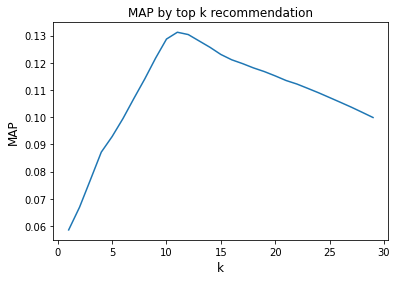

In [128]:
plt.plot(k_param_list, map_list)
plt.title('MAP by top k recommendation')
plt.ylabel('MAP', fontsize=12)
plt.xlabel('k', fontsize=12)
plt.show()